/tmp/ipykernel_10920/3952840847.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_azure = pd.read_sql_query(query, connection)


0     20672.36
1     33196.29
2     33196.29
3     33196.29
4     33196.29
5     20672.36
6     33196.29
7     33196.29
8     33196.29
9     17280.04
10    20672.36
Name: prediction, dtype: float64
0     18559.10
1     18722.42
2     18722.42
3     18841.48
4     31340.44
5     31340.44
6     31340.44
7     30822.76
8     30260.69
9     19453.44
10    19069.18
Name: predicted_price, dtype: float64


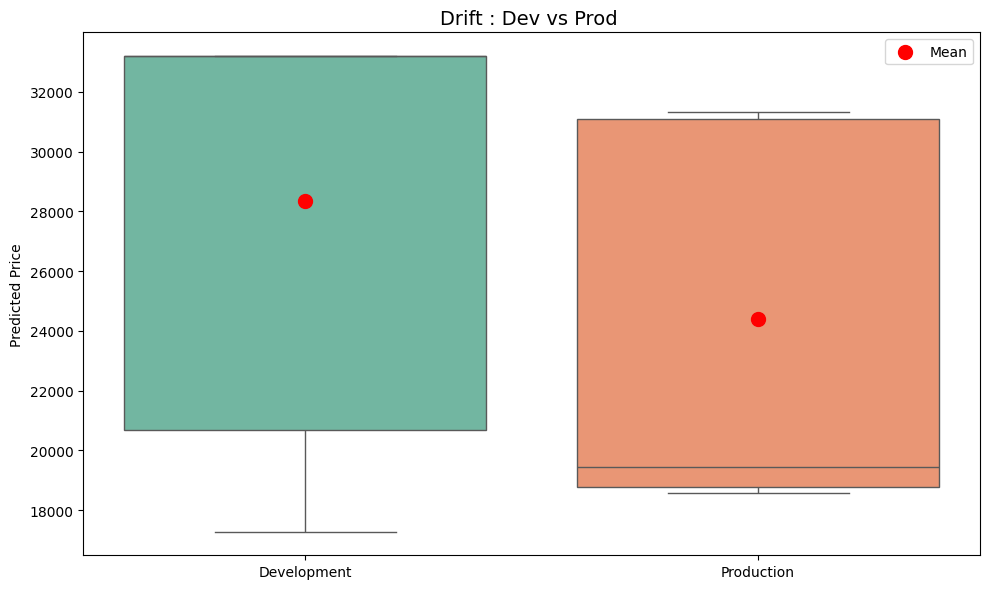

In [21]:
# Import necessary libraries
import sqlite3
import os
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Function to connect to SQLite
def connect_to_sqlite():
    db_path = os.path.abspath("cars.db")
    connection = sqlite3.connect(db_path)
    return connection

# Function to connect to Azure SQL
def connect_to_azure():
    connection_string = os.getenv("DATABASE_URL")
    connection = pyodbc.connect(connection_string)
    return connection

# Fetch the first 10 predictions from SQLite
def get_predictions_from_sqlite():
    connection = connect_to_sqlite()
    query = "SELECT prediction FROM Predictions" # LIMIT 10"
    df_sqlite = pd.read_sql_query(query, connection)
    connection.close()
    return df_sqlite

# Fetch the first 10 predicted prices from Azure SQL
def get_predictions_from_azure():
    connection = connect_to_azure()
    # query = "SELECT TOP 10 predicted_price FROM CarPredictions"
    query = "SELECT * FROM [dbo].[CarPredictions] WHERE predicted_price BETWEEN 18500 AND 40000;" 
    df_azure = pd.read_sql_query(query, connection)
    connection.close()
    return df_azure

# Plotting side-by-side box plots for predictions with mean values
def plot_comparisons(df_sqlite, df_azure):
    # Create a new DataFrame with both datasets for easier comparison
    combined_data = pd.DataFrame({
        'Development': df_sqlite['prediction'],
        'Production': df_azure['predicted_price']
    })
    print(df_sqlite['prediction'])
    print(df_azure['predicted_price'])
    # Calculate mean values
    means = combined_data.mean()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Create box plots for both prediction sets
    sns.boxplot(data=combined_data, palette="Set2")
    
    # Add mean values to the plot
    for i, mean in enumerate(means):
        plt.scatter(i, mean, color='red', label='Mean' if i == 0 else "", s=100, zorder=5)

    # Add titles and labels
    plt.title("Drift : Dev vs Prod ", fontsize=14)
    plt.ylabel("Predicted Price")
    # plt.xlabel("Source")
    
    # Show the plot with legends
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fetch predictions
    df_sqlite_predictions = get_predictions_from_sqlite()
    df_azure_predictions = get_predictions_from_azure()

    # Plot box plots with mean values
    plot_comparisons(df_sqlite_predictions, df_azure_predictions)

In [15]:
# Import necessary libraries
import sqlite3
import os
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from dotenv import load_dotenv


# Load environment variables from .env file
load_dotenv()

# Function to connect to SQLite
def connect_to_sqlite():
    db_path = os.path.abspath("cars.db")
    connection = sqlite3.connect(db_path)
    return connection

# Function to connect to Azure SQL
def connect_to_azure():
    connection_string = os.getenv("DATABASE_URL")
    connection = pyodbc.connect(connection_string)
    return connection

# Fetch the first 10 predictions from SQLite
def get_predictions_from_sqlite():
    connection = connect_to_sqlite()
    query = "SELECT prediction FROM Predictions LIMIT 10"
    df_sqlite = pd.read_sql_query(query, connection)
    connection.close()
    return df_sqlite

# Fetch the first 10 predicted prices from Azure SQL
def get_predictions_from_azure():
    connection = connect_to_azure()
    query = "SELECT TOP 10 predicted_price FROM CarPredictions"
    df_azure = pd.read_sql_query(query, connection)
    connection.close()
    return df_azure


# Load X_test and y_test from saved pickle files
with open("model/X_test.pkl", "rb") as f:   
    X_test = pickle.load(f)

with open("model/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Now X_test and y_test are the same as the ones used during model training

import requests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# API URL of your deployed model
# URL of your deployed FastAPI
API_URL = "http://20.19.201.109:8000/predict/"
token = os.getenv("token")

def get_predictions_from_api(X_test):
    predictions = []
    for _, row in X_test.iterrows():
        data = row.to_dict()  # Convert the row into a dictionary for JSON request
        
        # Add token to headers
        headers = {
            "Authorization": f"Bearer {token}",
            "Content-Type": "application/json"
        }
        print(f"Input data for API: {data}")
        # Send input data to FastAPI for prediction
        response = requests.post(API_URL, json=data, headers=headers)
        
        if response.status_code == 200:
            # Extract predicted price from the API response
            predicted_price = response.json().get("predicted_price")
            predictions.append(predicted_price)
        else:
            # Log the error message and response
            print(f"API error for row: {row}")
            print(f"Response status code: {response.status_code}")
            print(f"Response content: {response.content}")  # Print response content for debugging
    return predictions


# Get predictions from the deployed model
api_predictions = get_predictions_from_api(X_test)

# Compare predictions with the real values (y_test)
mae = mean_absolute_error(y_test, api_predictions)
mse = mean_squared_error(y_test, api_predictions)
r2 = r2_score(y_test, api_predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Input data for API: {'etat_de_route': 0, 'carburant': 'essence', 'turbo': 'atmosphérique', 'nombre_portes': 'quatre', 'type_vehicule': 'berline', 'roues_motrices': 'propulsion', 'emplacement_moteur': 'avant', 'empattement': 2.63, 'longueur': 4.8006, 'largeur': 1.69926, 'hauteur': 1.41478, 'poids_vehicule': 1465.10216, 'type_moteur': 'ohc', 'nombre_cylindres': 'six', 'taille_moteur': 3.4249039000000003, 'systeme_carburant': 'mpfi', 'taux_alésage': 91.948, 'course': 86.106, 'taux_compression': 8.0, 'chevaux': 182, 'tour_moteur': 5400, 'consommation_ville': 14.700875, 'consommation_autoroute': 10.691545454545455, 'marque': 'bmw', 'modèle': 'x4'}
API error for row: etat_de_route                         0
carburant                       essence
turbo                     atmosphérique
nombre_portes                    quatre
type_vehicule                   berline
roues_motrices               propulsion
emplacement_moteur                avant
empattement                        2.63
longueur  

ValueError: Found input variables with inconsistent numbers of samples: [41, 0]

In [14]:
print(X_test.head())

     etat_de_route carburant          turbo nombre_portes     type_vehicule  \
15               0   essence  atmosphérique        quatre           berline   
9                0   essence          turbo          deux  berline compacte   
115              0   essence  atmosphérique        quatre           berline   
78               2   essence  atmosphérique          deux  berline compacte   
66               0    diesel  atmosphérique        quatre           berline   

            roues_motrices emplacement_moteur  empattement  longueur  largeur  \
15              propulsion              avant         2.63   4.80060  1.69926   
9    quatre roues motrices              avant         2.53   4.52628  1.72466   
115             propulsion              avant         2.74   4.74218  1.73736   
78                traction              avant         2.38   3.99542  1.63576   
66              propulsion              avant         2.66   4.44500  1.67894   

     ...  systeme_carburant  taux_alés